In [13]:
# !pip install python-Levenshtein -q
# !pip install fuzzywuzzy -q
# !pip install mpl_toolkits.basemap

In [151]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from fuzzywuzzy import process
#New imports :
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from decimal import Decimal


pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.width', 500)

In [152]:
csv_file_path = "./project_3.csv"
original_df = pd.read_csv(csv_file_path)
df = original_df.copy()
#felix

# Simple Data Exploration over the whole dataset

In [3]:
df_columns = [column for column in df.columns]
print(df_columns)

['prefix', 'lastname', 'firstname', 'firstname_mother', 'firstname_father', 'description', 'inquiry', 'dob', 'account_creation_date', 'last_transaction_date', 'account_resiliation_date', 'first_contact_date', 'last_contact_date', 'latlon_home', 'latlon_work', 'x35_bank_branch', 'email_work', 'email_personnal', 'email_sso', 'email_vpn', 'xml_authent_token', 'profile_json', 'cia_info_json', 'salary', 'first_salary', 'taxable_income', 'transaction_amount', 'credit_card_score', 'credit_card_number', 'weight', 'height', 'shoe_size', 'bank_balance', 'address', 'city', 'zip', 'country', 'customer_code', 'customer_uid', 'android_platform', 'user_agent', 'blog_url', 'customer_segment_code', 'customer_market_code', 'customer_fico_score']


In [213]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   prefix                    10000 non-null  object 
 1   lastname                  10000 non-null  object 
 2   firstname                 10000 non-null  object 
 3   firstname_mother          10000 non-null  object 
 4   firstname_father          9915 non-null   object 
 5   description               10000 non-null  object 
 6   inquiry                   10000 non-null  object 
 7   dob                       10000 non-null  object 
 8   account_creation_date     10000 non-null  object 
 9   last_transaction_date     10000 non-null  object 
 10  account_resiliation_date  10000 non-null  object 
 11  first_contact_date        10000 non-null  object 
 12  last_contact_date         10000 non-null  object 
 13  latlon_home               10000 non-null  object 
 14  latlon_

In [212]:
print(df.describe())

             salary  first_salary  taxable_income  transaction_amount  credit_card_score  credit_card_number        weight        height     shoe_size  bank_balance           zip  customer_code  customer_segment_code  customer_market_code  customer_fico_score
count  1.000000e+04  1.000000e+04    10000.000000        10000.000000       10000.000000        1.000000e+04  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000         9464.0            8965.000000           8845.000000          8582.000000
mean   3.410324e+06 -3.562806e+06    11734.681400          891.612898          47.896294        4.990246e+15     66.658873    178.285417     41.985855   1497.924500  50506.264100           27.0              14.855438         266412.692369            18.704847
std    1.817860e+07  1.960390e+07     8062.124853          521.556578          18.523971        2.872614e+15     15.629118     37.951751      1.947280    578.267814  28798.239246            0.0               5.740120    

In [339]:
missing_values_count = df.isna().sum()
missing_values_count_non_zero = missing_values_count[missing_values_count > 0]
print(f"Number of missing values per column:\n"
      f"{missing_values_count_non_zero}")

Number of missing values per column:
firstname_father           85
customer_code             536
customer_segment_code    1035
customer_market_code     1155
customer_fico_score      1418
dtype: int64


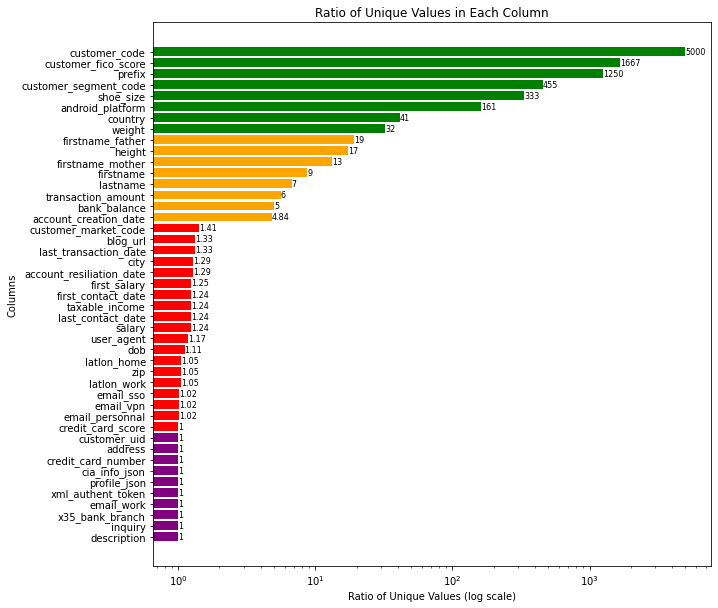

In [340]:
unique_count = []
for column in df.columns:
    ratio_unique_value = len(df[column]) / len(df[column].unique())
    unique_count.append((column, ratio_unique_value))

unique_count.sort(key=lambda x: x[1])

thresholds = [1, 2, 20]  
colors = ['purple', 'red', 'orange', 'green']

color_map = np.digitize([ratio for _, ratio in unique_count], thresholds, right=True)

columns, ratios = zip(*unique_count)
plt.figure(figsize=(10, 10))
bar_plot = plt.barh(columns, ratios, color=[colors[idx] for idx in color_map])
plt.xscale('log')
plt.xlabel('Ratio of Unique Values (log scale)')
plt.ylabel('Columns')
plt.title('Ratio of Unique Values in Each Column')

for i, ratio in enumerate(ratios):
    if ratio > 5 or int(ratio * 100) % 10 == 0:
        text = f'{ratio:.0f}'
    else:
        text = f'{ratio:.2f}'
    plt.text(ratio, i, text, ha='left', va='center', color='black', fontsize=8)

plt.show()

In [ ]:
max_unique_val = 30

valid_columns_count = sum(1 for column_name in df.columns if len(df[column_name].value_counts().index) < 20)

num_rows = (valid_columns_count + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

if num_rows == 1 and num_cols == 1:
    axs = [axs]

subplot_index = 0
for column_name in df.columns:
    unique_values_distribution = df[column_name].value_counts()
    if len(unique_values_distribution.index) < max_unique_val:
        row_index = subplot_index // num_cols
        col_index = subplot_index % num_cols

        axs[row_index, col_index].bar(unique_values_distribution.index, unique_values_distribution.values)
        axs[row_index, col_index].set_title('Column "{}"'.format(column_name))
        axs[row_index, col_index].set_xlabel('Unique Values')
        axs[row_index, col_index].set_ylabel('Count')
        axs[row_index, col_index].tick_params(axis='x', rotation=45)
        axs[row_index, col_index].grid(axis='y', linestyle='--', alpha=0.7)
        
        subplot_index += 1

# Adjust layout
plt.tight_layout()
plt.show()

# Data Visualization of all 45 columns

# String Cleaning 0 / 23

## Normal 0 / 18

In [414]:
def step_1(interested_column):
    print(df[interested_column])
    missing_values_count = df[interested_column].isna().sum()
    print(f'There are {missing_values_count} missing value(s) in the column {interested_column}')

### Unique value 0 / 7

#### lastname ❌  
typing errors (Ba+rett, Ev$ns…) + incomplete> remove special characters.

In [415]:
interested_column = 'lastname'

In [416]:
step_1(interested_column)

0        Figueroa
1           Smith
2       Nicholson
3          Harvey
4         Sanchez
          ...    
9995      Coleman
9996        Dixon
9997      V(zquez
9998       Greene
9999         Wolf
Name: lastname, Length: 10000, dtype: object
There are 0 missing value(s) in the column lastname


In [417]:
def identify_inconsistencies(df):
    inconsistency_types = {}
    inconsistency_count = 0

    # Regular expression pattern to match non-letter characters
    pattern = re.compile(r'[^a-zA-Z]')

    for index, row in df.iterrows():
        lastname = row['lastname']
        if re.search(pattern, lastname):
            inconsistency = re.findall(pattern, lastname)
            inconsistency = ''.join(inconsistency)
            if inconsistency in inconsistency_types:
                inconsistency_types[inconsistency] += 1
            else:
                inconsistency_types[inconsistency] = 1
            inconsistency_count += 1

    return inconsistency_types, inconsistency_count

# Identify and count inconsistencies
inconsistency_types, inconsistency_count = identify_inconsistencies(df)

# Display the summary of inconsistencies
print("Summary of inconsistencies:")
for inconsistency, count in inconsistency_types.items():
    print(f"Inconsistency '{inconsistency}': {count} occurrences")
print("Number of inconsistent last names:", inconsistency_count)

Summary of inconsistencies:
Inconsistency '`': 13 occurrences
Inconsistency '}': 15 occurrences
Inconsistency '~': 15 occurrences
Inconsistency ',': 15 occurrences
Inconsistency '^': 18 occurrences
Inconsistency '!': 19 occurrences
Inconsistency '*': 10 occurrences
Inconsistency '<': 17 occurrences
Inconsistency '#': 13 occurrences
Inconsistency '%': 22 occurrences
Inconsistency '?': 14 occurrences
Inconsistency ''': 15 occurrences
Inconsistency '\\': 19 occurrences
Inconsistency ')': 11 occurrences
Inconsistency '_': 16 occurrences
Inconsistency '(': 17 occurrences
Inconsistency '>': 18 occurrences
Inconsistency ']': 16 occurrences
Inconsistency '/': 26 occurrences
Inconsistency ';': 13 occurrences
Inconsistency '=': 14 occurrences
Inconsistency '{': 14 occurrences
Inconsistency '"': 21 occurrences
Inconsistency '[': 17 occurrences
Inconsistency '-': 15 occurrences
Inconsistency '@': 16 occurrences
Inconsistency ':': 16 occurrences
Inconsistency '.': 9 occurrences
Inconsistency '+': 1

In [ ]:
def identify_inconsistencies(df):
    inconsistencies = []
    inconsistency_count = 0

    # Regular expression pattern to match non-letter characters
    pattern = re.compile(r'[^a-zA-Z]')

    for index, row in df.iterrows():
        lastname = row['lastname']
        if re.search(pattern, lastname):
            inconsistencies.append((index, lastname))
            inconsistency_count += 1

    return inconsistencies, inconsistency_count

# Identify and count inconsistencies
inconsistencies, inconsistency_count = identify_inconsistencies(df)

# List of correct last names
correct_lastnames = df[~df.index.isin([i[0] for i in inconsistencies])]['lastname'].tolist()

# Function to infer correct last names and check for invalid characters
def infer_correct_lastname(incorrect_lastname, correct_lastnames, pattern):
    min_length = len(re.sub(pattern, '', incorrect_lastname)) + 1
    filtered_names = [name for name in correct_lastnames if len(name) >= min_length]
    closest_match, score = process.extractOne(incorrect_lastname, filtered_names)
    if re.search(pattern, closest_match):
        return None, closest_match, score
    return closest_match, None, score

# Apply inference to each incorrect last name
inferred_lastnames = []
names_without_match = []
for index, row in df.iterrows():
    lastname = row['lastname']
    if index in [i[0] for i in inconsistencies]:  # Check if the last name is inconsistent
        inferred_lastname, invalid, score = infer_correct_lastname(lastname, correct_lastnames, re.compile(r'[^a-zA-Z]'))
        if inferred_lastname:
            inferred_lastnames.append((index, lastname, inferred_lastname, invalid, score))
        else:
            names_without_match.append(lastname)

# Display the inferred last names
print(f"The {len(inferred_lastnames)} Inferred Last Names:")

for index, incorrect, inferred, invalid, score in inferred_lastnames:
    print(f"Row {index}: {incorrect} -> {inferred} (Similarity Score: {score})")

# Print names without a match for manual inference
print("Names without a match for manual inference:")
print(names_without_match)

#### firstname ✅
typing errors with spaces (L   sa, Ell   n…) > remove spaces and add letter (names library).

#### firstname_mother ✅
 typing errors (Juâ€‹ie, Laâ€‹ra…)

#### firstname_father ✅
 Incomplete words (Jcob, onald…) + 92 missing values.

#### description ❌  
?

#### inquiry ❌  
?

#### address ❌  
?

### Categorical 0 / 7

#### prefix ❌  
the prefix are not always well suited to the user.


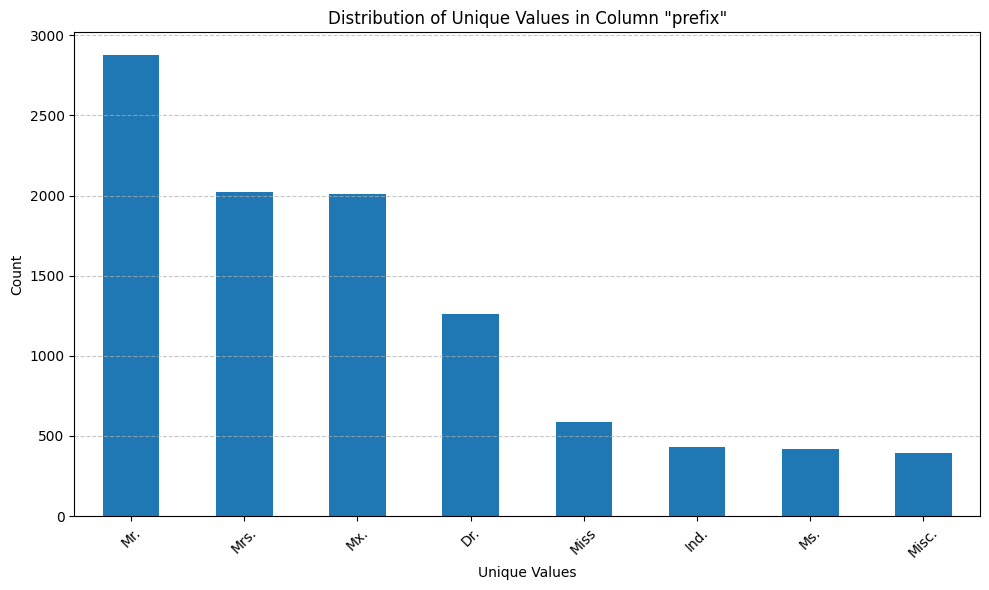

8


In [ ]:
column_name = 'prefix'

unique_values_distribution = df[column_name].value_counts()

# Plot the distribution of unique values
plt.figure(figsize=(10, 6))
unique_values_distribution.plot(kind='bar')
plt.title('Distribution of Unique Values in Column "{}"'.format(column_name))
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(len(unique_values_distribution.index))

#### city ❌
?

#### country ❌  
?  
(some names are to long like “British Indian Ocean Territory (Chagos Archipelago)”, “holy see (vatican city)”, “Slovakia (Slovak Republic)”)

#### android_platform ❌  
maybe android is repeated ? (it ranges from 1 to 9 and ?)

#### user_agent ❌  
some feld have “PWNED” added randomly

#### customer_segment_code ❌  
992 missing values

#### customer_market_code ❌  
 1141 missing values and nonsense.

### Email 0 / 4

#### email_personnal ❌  
some unexpected characters ex:(hollybailey@example..org).

#### email_sso ❌  
unexpected characters ex:(paulthornton@example.Œ≥rg or craigrobe‚Ä¢ts@example.com).

#### email_vpn ❌  
unexpected characters at the end of the email adresse (​​douglasjohn@yahoo.comhg).

#### email_work ❌  
some unexpected characters ex:(jason72@!dwards-butler.info)

### Hardest - 0 / 5

#### blog_url ❌ url  
?

#### customer_uid ❌hexadecimal  
There doesn't seem to be any inherent issue with this string as a UID. However, depending on the context in which it's used, there are a few considerations:  
Uniqueness: UUIDs are typically used to uniquely identify entities. Ensure that this UUID is generated using a method that guarantees uniqueness within the intended scope (e.g., globally unique for UUIDv4).  
length: UUIDs are usually 128 bits or 32 hexadecimal characters long (excluding hyphens if present). This one seems to be of the correct length.  
Representation: Make sure the UUID is properly represented and stored in whatever system or database it's used in. For example, it might be stored as a string or a binary value depending on the requirements.  

#### xml_authent_token ❌ xml code  
?

#### profile_json ❌ json code  
?

In [ ]:
df['profile_json']

0       {'job': 'Development worker, international aid', 'company': 'Williams-Brown', 'ssn': '221-23-9840', 'residence': '99174 Dunn Knolls\\nNew Kerryland, IL 97270', 'current_location': (Decimal('-27.9293375'), Decimal('26.372802')), 'blood_group': 'AB-', 'website': ['http://www.nelson-mejia.com/', 'https://mcmahon.net/', 'https://www.cannon.biz/', 'http://hughes.com/'], 'username': 'james48', 'name': 'James Burnett', 'sex': 'M', 'address': '4742 Perez Stravenue Suite 954\\nWest Emilymouth, IA 95107', 'mail': 'elizabethanderson@hotmail.com', 'birthdate': datetime.date(2010, 8, 7)}
1                            {'job': 'Copy', 'company': 'Walter, Stevens and Greene', 'ssn': '598-99-8638', 'residence': '1947 Austin Meadows Apt. 804\\nPattonville, PW 11984', 'current_location': (Decimal('-63.090949'), Decimal('148.956581')), 'blood_group': 'A-', 'website': ['https://www.maxwell.com/', 'http://www.bell-bennett.net/', 'http://www.weber-bishop.biz/', 'http://gomez-lyons.com/'], 'username': 

#### cia_info_json ❌ json code  
?

# Date 0 / 6

#### dob ✅ 
variation in date structure (10/7/2003 or 1987-03-58) > choose one + Customer that have more than 100 yo.

In [419]:
def plot_yearly_distribution(df, date_column):
    df[date_column] = df[date_column].astype(str)
    df['year'] = df[date_column].str.extract(r'(\d{4})')
    
    year_counts = df['year'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    year_counts.plot(kind='bar')
    plt.xlabel('Year')
    plt.ylabel('Number of Transactions')
    plt.title('Distribution of Transactions per Year')
    plt.show()
    
    df.drop(columns=['year'], inplace=True)

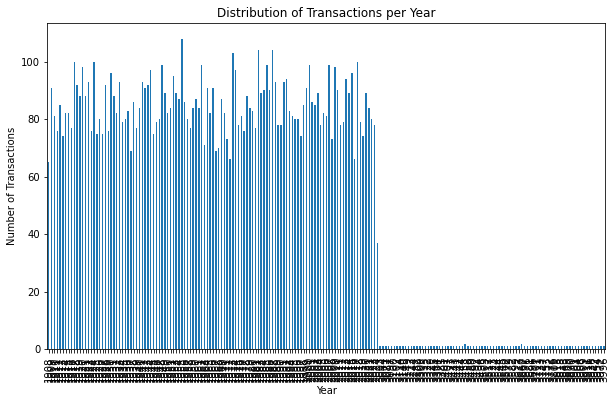

In [420]:
plot_yearly_distribution(df, 'dob')

In [421]:
def return_invalid_dates(dataframe):
    formatted_dates = []
    invalid_dates = []

    for date in dataframe:
        try:
            formatted_dates.append(pd.to_datetime(date))
        except ValueError:
            print(f"Error in date conversion : {date}")
            invalid_dates.append(date)
            
    return print(f"\nNumber of invalid dates in 'dob' column is: "
    f"{len(invalid_dates)}")

In [422]:
return_invalid_dates(df['dob'])

Error in date conversion : 1971-05-41
Error in date conversion : 1910-05-82
Error in date conversion : 1984-06-64
Error in date conversion : 1915-04-47
Error in date conversion : 1959-20-18
Error in date conversion : 1956-10-46
Error in date conversion : 3114-02-16
Error in date conversion : 3044-07-21
Error in date conversion : 3524-03-16
Error in date conversion : 1992-20-30
Error in date conversion : 1916-09-67
Error in date conversion : 1954-02-45
Error in date conversion : 3843-12-09
Error in date conversion : 1938-11-53
Error in date conversion : 3707-10-19
Error in date conversion : 3747-08-17
Error in date conversion : 1971-10-94
Error in date conversion : 1925-14-10
Error in date conversion : 1985-05-80
Error in date conversion : 2018-13-20
Error in date conversion : 1966-05-54
Error in date conversion : 1916-04-64
Error in date conversion : 3904-07-09
Error in date conversion : 1954-20-10
Error in date conversion : 3572-10-08
Error in date conversion : 1965-18-29
Error in dat

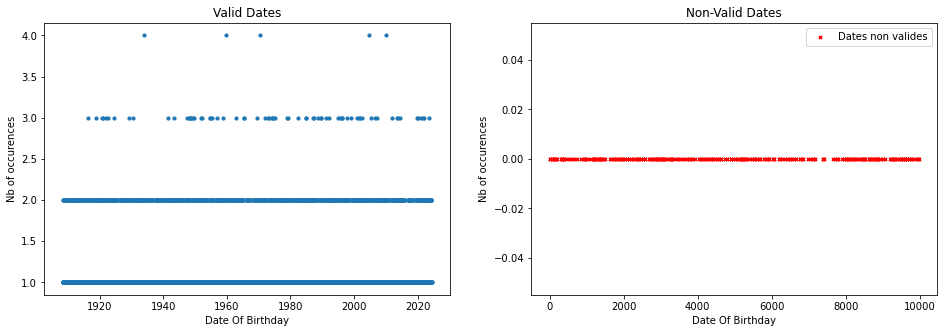

In [423]:
dates = [pd.to_datetime(date, errors='coerce', dayfirst=True) for date in df['dob']]

dates_df = pd.DataFrame({'dob': dates}).head(10000)
valid_dates_df = dates_df.dropna()
invalid_dates_df = dates_df[dates_df.isnull().any(axis=1)]
valid_date_counts = valid_dates_df['dob'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.scatter(valid_date_counts.index, valid_date_counts.values, marker='o', s=10)
ax1.set_title('Valid Dates')
ax1.set_xlabel('Date Of Birthday')
ax1.set_ylabel('Nb of occurences')

ax2.scatter(invalid_dates_df.index, [0] * len(invalid_dates_df), marker='x', s=10, color='red', label='Dates non valides')
ax2.set_title('Non-Valid Dates')
ax2.set_xlabel('Date Of Birthday')
ax2.set_ylabel('Nb of occurences')

ax2.legend()
plt.show()

We replace invalid dates with a placeholder date

In [424]:
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

invalid_indices = df[df['dob'].isnull()].index

random_placeholders = pd.to_datetime(
    {
        'year': np.random.randint(1900, 2022, size=len(invalid_indices)),
        'month': np.random.randint(1, 13, size=len(invalid_indices)),
        'day': np.random.randint(1, 29, size=len(invalid_indices))
    }
)

df.loc[invalid_indices, 'dob'] = random_placeholders

In [425]:
return_invalid_dates(df['dob'])


Number of invalid dates in 'dob' column is: 0


#### account_creation_date ✅  
  Contains invalid leap day dates (February 29) for non-leap years -> errors  date conversion

In [426]:
return_invalid_dates(df['account_creation_date'])

Error in date conversion : 1977-02-29
Error in date conversion : 1974-02-29
Error in date conversion : 2011-02-29
Error in date conversion : 1986-02-29
Error in date conversion : 1987-02-29
Error in date conversion : 1973-02-29
Error in date conversion : 2001-02-29
Error in date conversion : 1986-02-29
Error in date conversion : 1999-02-29
Error in date conversion : 1978-02-29
Error in date conversion : 1989-02-29
Error in date conversion : 1990-02-29
Error in date conversion : 2022-02-29
Error in date conversion : 1999-02-29
Error in date conversion : 2001-02-29
Error in date conversion : 2021-02-29
Error in date conversion : 1995-02-29
Error in date conversion : 2013-02-29
Error in date conversion : 1977-02-29
Error in date conversion : 1974-02-29
Error in date conversion : 1974-02-29
Error in date conversion : 1971-02-29
Error in date conversion : 2021-02-29
Error in date conversion : 1995-02-29
Error in date conversion : 1982-02-29
Error in date conversion : 1995-02-29
Error in dat

In [427]:
def replace_leap_day(date_str):
    date_str = date_str.replace('02-29', '03-01')
    return date_str

def convert_to_date(date_str):
    try:
        return pd.to_datetime(date_str, dayfirst=True)
    except ValueError:
        return date_str

df['account_creation_date'] = df['account_creation_date'].apply(replace_leap_day)
df['account_creation_date'] = df['account_creation_date'].apply(convert_to_date)

return_invalid_dates(df['account_creation_date'])


Number of invalid dates in 'dob' column is: 0


#### last_transaction_date ✅ 
 Recurrent date as an outlier (1/1/1970 0:00) + older than creation date ?

In [428]:
df = original_df.copy()

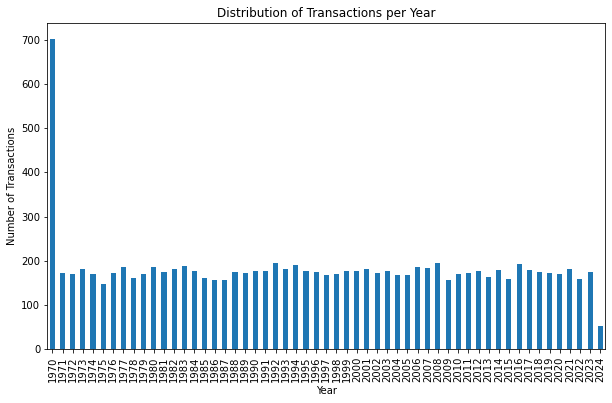

In [429]:
plot_yearly_distribution(df, 'last_transaction_date')

In [430]:
df['last_transaction_date'] = df.apply(
    lambda row: row['account_creation_date'] if row['last_transaction_date'] == '1970-01-01 00:00:00' else row['last_transaction_date'],
    axis=1
)

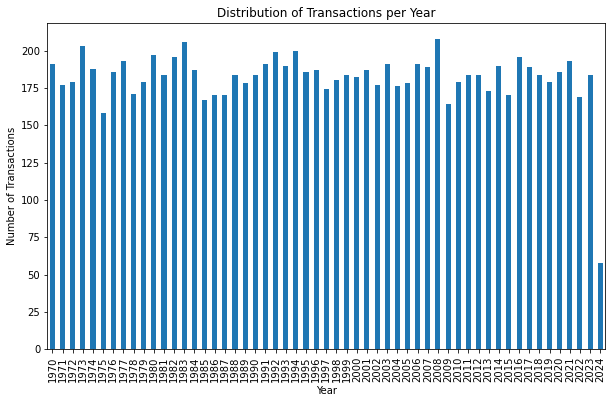

In [431]:
plot_yearly_distribution(df, 'last_transaction_date')

#### account_resiliation_date ❌  
?  
resiliation_date before creation_date ? and outlier in 1900 ? 

In [432]:
return_invalid_dates(df['account_resiliation_date'])


Number of invalid dates in 'dob' column is: 0


In [433]:
df['account_resiliation_date'].iloc[41]

'2007-05-06'

In [434]:
only1900 = df[df['account_resiliation_date'].str.contains('1900')]
only1900['account_resiliation_date']

27      1900-09-08
33      1900-12-21
40      1900-08-15
93      1900-11-25
99      1900-12-09
           ...    
9944    1900-10-11
9947    1900-04-18
9952    1900-04-28
9980    1900-02-01
9988    1900-09-24
Name: account_resiliation_date, Length: 492, dtype: object

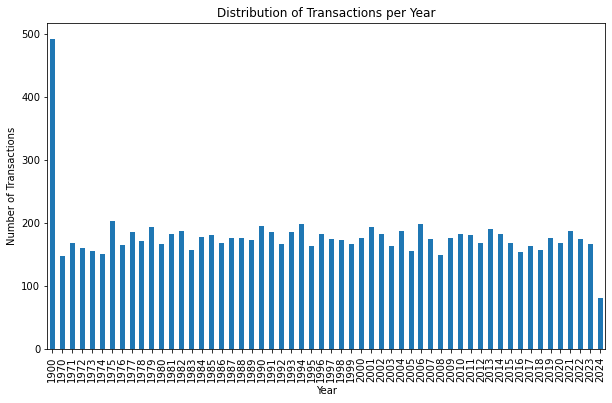

In [435]:
plot_yearly_distribution(df, 'account_resiliation_date')

#### first_contact_date ✅
inverted value between first_contact_date and last_contact_date ex: ( 02/10/1998 in first_contact_date and 12/08/1993 in last_contact_date)  

In [436]:
original_df[['first_contact_date','last_contact_date']]

,first_contact_date,last_contact_date
0,1981-07-04,2022-09-11
1,1979-01-26,2012-01-10
2,2020-10-13,1973-10-09
3,2021-05-26,1990-03-11
4,1980-03-25,2020-11-22
...,...,...
9995,2010-05-14,2013-03-28
9996,1982-02-12,2022-09-23
9997,1980-10-01,1971-12-09
9998,2004-06-18,2008-09-06


In [437]:
df['first_contact_date'] = pd.to_datetime(df['first_contact_date'], format='%m/%d/%Y', errors='coerce')
df['last_contact_date'] = pd.to_datetime(df['last_contact_date'], format='%m/%d/%Y', errors='coerce')

mask = df['first_contact_date'] > df['last_contact_date']

temp = df.loc[mask, 'first_contact_date']
df.loc[mask, 'first_contact_date'] = df.loc[mask, 'last_contact_date']
df.loc[mask, 'last_contact_date'] = temp

df[['first_contact_date','last_contact_date']]

,first_contact_date,last_contact_date
0,NaT,NaT
1,NaT,NaT
2,NaT,NaT
3,NaT,NaT
4,NaT,NaT
...,...,...
9995,NaT,NaT
9996,NaT,NaT
9997,NaT,NaT
9998,NaT,NaT


#### last_contact_date ✅
**09**/**16**/1971 instead of **16**/**09**/1971. 

# Number 0 / 16

## Float 0 / 5

### Coordinate 0 / 3

#### latlon_home ✅ 

- Problem: Coordinates are represented with the 'Decimal' type, which is not ideal for standard use. Example : (Decimal('-29.146587'), Decimal('-69.661657')) instead of -29.146587 latitude and -69.661657 longitude. Default value at (90, 0). Float: lat -90 to 90, long -180 to 180  
- Cause: The data may have been stored or retrieved in this format.
- Solution: Convert the coordinates to standard floating-point numbers for easier handling.

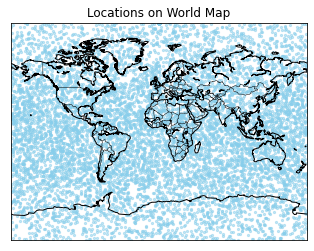

In [438]:
def plot_locations_on_world_map(df, column_name):
    coordinates = [eval(coord) for coord in df[column_name]]
    coordinates = [(float(lat), float(lon)) for lat, lon in coordinates]

    lats, lons = zip(*coordinates)
    m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

    m.drawcoastlines()
    m.drawcountries()
    
    x, y = m(lons, lats)

    m.scatter(x, y, s=5, color='skyblue', alpha=0.5)
    plt.title('Locations on World Map')
    plt.show()

plot_locations_on_world_map(df, 'latlon_home')

In [439]:
def extract_lat_lon(string):
    pattern = r"[-+]?\d*\.\d+|\d+"
    numbers = re.findall(pattern, string)
    if len(numbers) == 2:
        return (Decimal(numbers[0]), Decimal(numbers[1]))
    else:
        return None

df['latlon_home'] = df['latlon_home'].apply(extract_lat_lon)

#### latlon_work ✅ 
- Problem: Same as latlon_home except for the default coordinate being at (-27.26765, 79.60243).
- Cause: The data may have been stored or retrieved in this format.
- Solution: Convert the coordinates to standard floating-point numbers for easier handling.

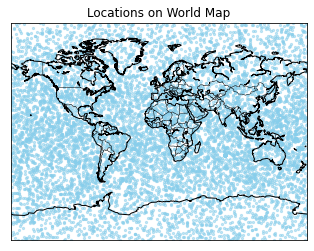

In [440]:
plot_locations_on_world_map(df, 'latlon_work')

In [441]:
df['latlon_work'] = df['latlon_work'].apply(extract_lat_lon)

#### x35_bank_branch ❌  

- Problem: Some coordinates, like ((Decimal('99.108555'), Decimal('-30.3705825')), are beyond the valid latitude and longitude ranges: -90 to 90 for latitude and -180 to 180 for longitude.
- Cause: This happens due to incorrect data entry or recording.
- Solution: To fix it, we convert the coordinates to floats and then ensure they fall within the valid range: adjusting latitude to -90 or 90 and longitude to -180 or 180 if necessary.

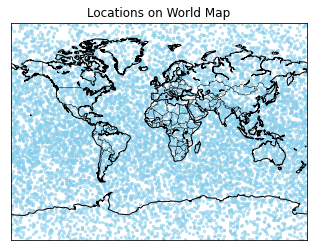

In [442]:
plot_locations_on_world_map(df, 'x35_bank_branch')

In [443]:
df['x35_bank_branch'] = df['x35_bank_branch'].apply(extract_lat_lon)

In [444]:
def clamp_coordinates(coord):
    lat, lon = coord
    lat = max(min(lat, Decimal('90')), Decimal('-90'))
    lon = max(min(lon, Decimal('180')), Decimal('-180'))
    return (lat, lon)

df['x35_bank_branch'] = df['x35_bank_branch'].apply(clamp_coordinates)

### Other 0 / 2

#### credit_card_score ✅  

- Problem: The 'credit_card_score' column has very precise float values, likely due to computer-generated data. The distribution of scores is uneven, with an unusual concentration around 0 to 20 and outliers near the main distribution.
- Cause: The precision in float values may be a result of computer-generated calculations, while the uneven distribution and outliers could stem from data collection inconsistencies.
- Solution: Round the float values to reduce precision and but no need to adjust the distribution by potentially filtering out scores below 20 because this can be linked to specifities in scoring system.

In [445]:
def plot_distribution(df,column):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    axes[0].hist(df[column], bins=20, color='skyblue', edgecolor='black')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Histogram')
    axes[0].grid(True)

    axes[1].boxplot(df[column], vert=False)
    axes[1].set_xlabel(column)
    axes[1].set_title('Box Plot')

    plt.show()

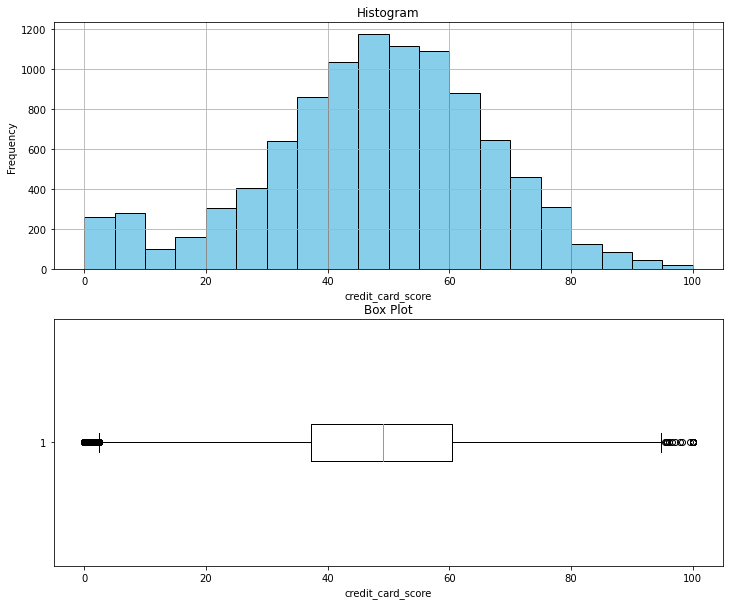

In [446]:
plot_distribution(df,'credit_card_score')

In [447]:
df['credit_card_score'] = df['credit_card_score'].round().astype(int)

#### shoe_size ✅  

- Problem: Shoe sizes are overly precise, such as 41.3812748610831, requiring rounding to a simpler format like 41.5.
- Cause: The precision in the shoe size values may be unnecessary or a result of data recording or processing.
- Solution: Round the shoe size values to a single precision, such as 41.5, to simplify and standardize the representation of shoe sizes.

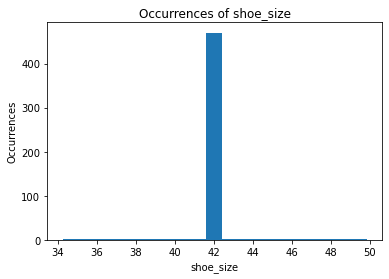

In [448]:
def plot_column_occurrences(df, column_name):
    column_values = df[column_name].value_counts().sort_index()

    plt.bar(column_values.index, column_values.values)
    plt.xlabel(column_name)
    plt.ylabel('Occurrences')
    plt.title(f'Occurrences of {column_name}')
    plt.show()

plot_column_occurrences(df, 'shoe_size')

In [449]:
df['shoe_size'] = df['shoe_size'].apply(lambda x: round(x * 2) / 2)

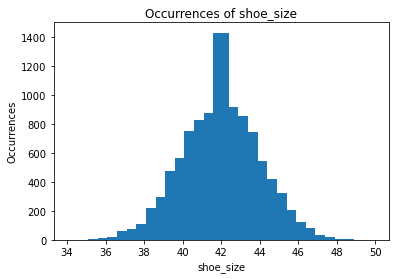

In [450]:
plot_column_occurrences(df, 'shoe_size')

Based on that explain the problem, the cause  and the solution to clean the data in few words, make it quick and simple

## Integer 0 / 11

### Pur Integer 0 / 9

#### salary ✅  
- Problem: The 'salary' column contains an outlier with a significant jump from 24999 to 165198.70230679.
- Cause: The outlier likely resulted from data entry error or a rare occurrence.
- Solution: Remove the outlier, particularly values above 1000000, to align it with the distribution of other values and maintain consistency in the dataset.

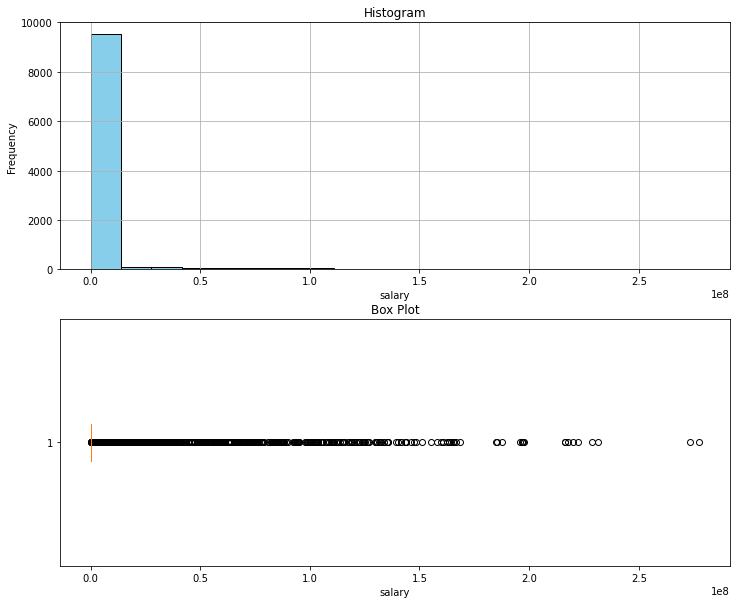

In [451]:
plot_distribution(df,'salary')

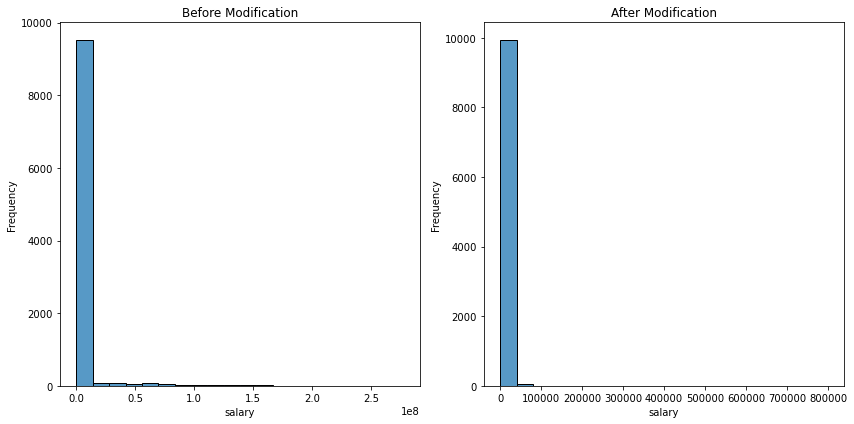

In [452]:
def distribution_of_outliers(df, column, start_value, order='asc'):
    if order == 'asc':
        outliers = df[df[column] >= start_value].index
    elif order == 'dsc':
        outliers = df[df[column] <= start_value].index
    non_outliers = df.drop(outliers)
    data_mean = non_outliers[column].mean()
    data_std = non_outliers[column].std()
    random_values = np.random.normal(loc=data_mean, scale=data_std, size=len(outliers))
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original DataFrame
    for i, outlier_index in enumerate(outliers):
        df_copy.loc[outlier_index, column] = random_values[i]
    df_copy[column] = df_copy[column].map(lambda x: np.abs(round(x, 1)))
    # Visualize the distribution before and after modifying outliers
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=20)
    plt.title('Before Modification')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df_copy[column], bins=20)
    plt.title('After Modification')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return df_copy

df = distribution_of_outliers(original_df, 'salary', 1000000, order='asc')


#### first_salary ✅
- Problem: The 'first_salary' column contains negative values, ranging from -1525444.1901449 to normal positive values.
- Cause: Negative values may result from data entry errors or anomalies in the dataset.
- Solution: Remove negative values and adjust the distribution to align with the remaining positive values, ensuring consistency in the dataset.

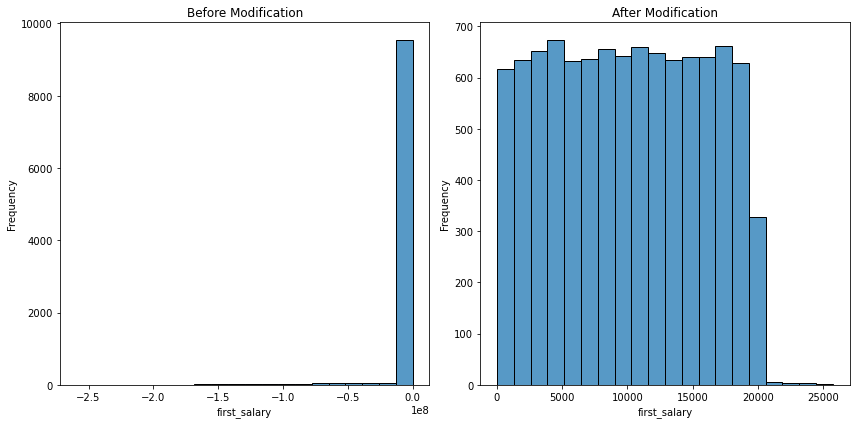

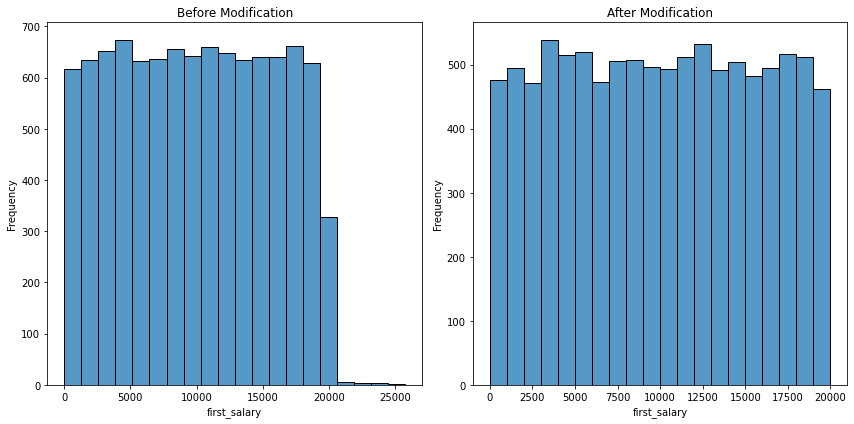

In [453]:
df = distribution_of_outliers(original_df, 'first_salary', 0, order='dsc')
df = distribution_of_outliers(df, 'first_salary', 20000, order='asc')

#### taxable_income ✅ 
- Problem: The 'taxable_income' column contains negative values ranging from -22811 to normal positive values.
- Cause: Negative values may indicate data entry errors or anomalies in the dataset.
- Solution: Remove the negative values and adjust the distribution of the remaining values to compensate for the removed values, ensuring consistency in the dataset.

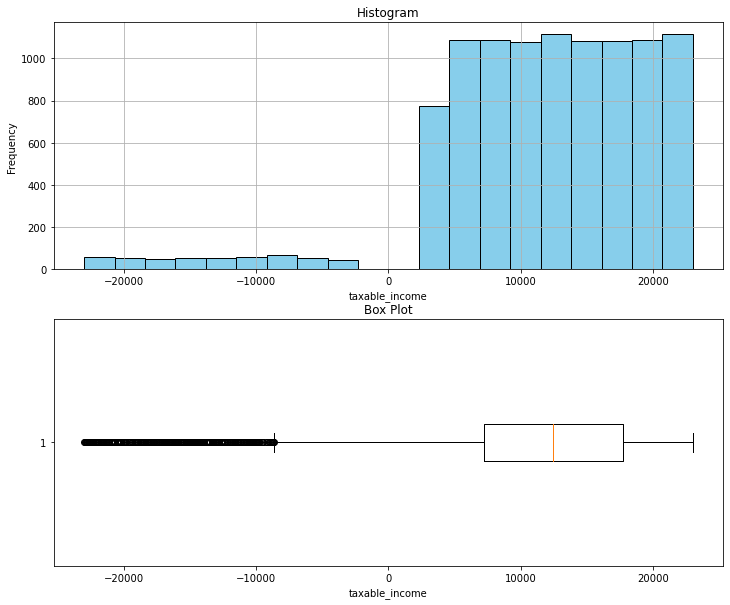

In [454]:
plot_distribution(original_df,'taxable_income')

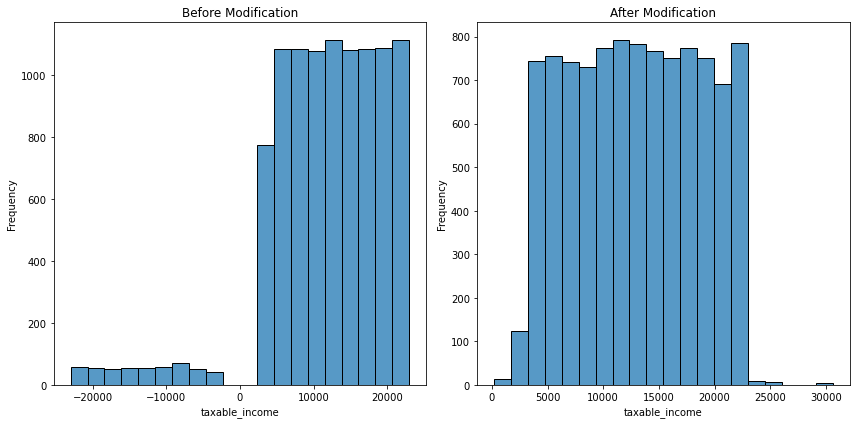

In [455]:
df = distribution_of_outliers(original_df, 'taxable_income', 0, order='dsc')

#### transaction_amount ✅
- Problem: The 'transaction_amount' column contains values that appear to be shifted from the pattern, such as .992, which might indicate an error.
- Cause: This could be due to data entry mistakes or inconsistencies in data recording processes.
- Solution: Round the values down to the nearest whole number to remove the irregular pattern.

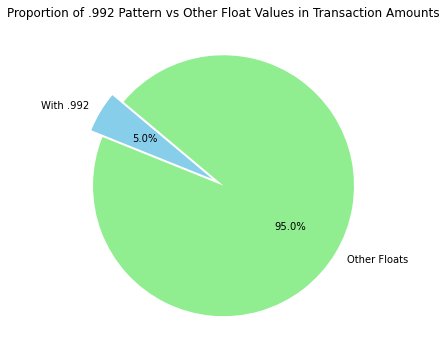

In [456]:
num_with_992 = df['transaction_amount'].apply(lambda x: str(x).endswith('.992')).sum()

num_floats = df['transaction_amount'].apply(lambda x: isinstance(x, float)).sum()

labels = ['With .992', 'Other Floats']
sizes = [num_with_992, num_floats - num_with_992]
colors = ['skyblue', 'lightgreen']
explode = (0.1, 0) 

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of .992 Pattern vs Other Float Values in Transaction Amounts')
plt.show()

In [457]:
df['transaction_amount'] = np.floor(df['transaction_amount']).astype(int)

#### credit_card_number ✅  
- Problem: Some card numbers in the dataset have missing digits, such as only 14 digits instead of the expected 16.
- Cause: This could occur due to data entry errors or incomplete data recording processes.
- Solution: Pad the card numbers with leading zeros until they reach 16 digits to ensure uniformity and consistency in the dataset.

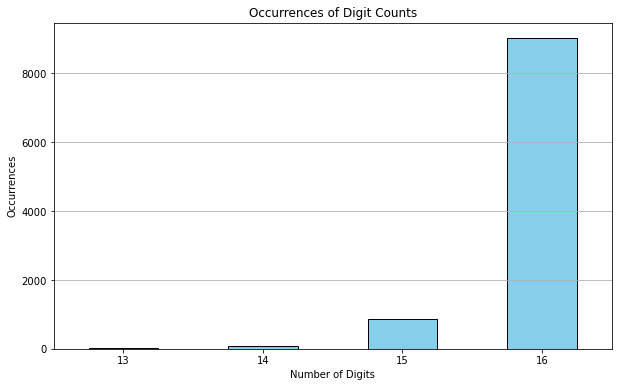

In [458]:
def plot_digit_count_distribution(df, column_name):
    df[column_name] = df[column_name].astype(str)
    df['digit_count'] = df[column_name].apply(len)

    digit_count_series = df['digit_count'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    digit_count_series.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Number of Digits')
    plt.ylabel('Occurrences')
    plt.title('Occurrences of Digit Counts')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

    df.drop(columns=['digit_count'], inplace=True)

plot_digit_count_distribution(df, 'credit_card_number')

In [459]:
original_df['credit_card_number'].sample(n=5, random_state=41)

9745     600508185045257
4492    1828994961782432
3439    8611535018225561
6077    9051865914186312
5372    7916112215138915
Name: credit_card_number, dtype: int64

In [460]:
df['credit_card_number'] = df['credit_card_number'].astype(str).apply(lambda x: x.ljust(16, '0'))

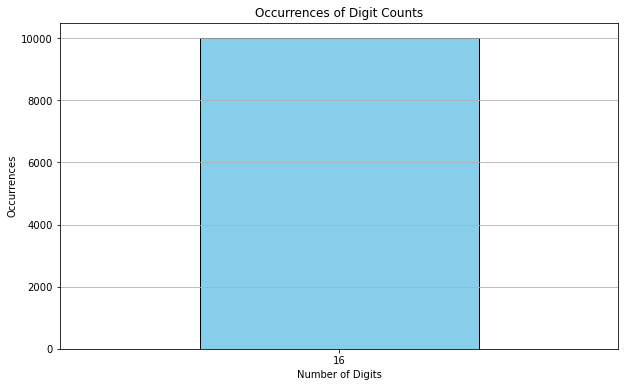

In [461]:
plot_digit_count_distribution(df, 'credit_card_number')

#### weight ✅  
- Problem: The 'transaction_amount' column contains extremely low values, such as 0.0118407752664808.
- Cause: Slippage errors during data recording or processing could lead to extremely low values.
- Solution: Remove the outliers and adjust the distribution of the remaining values to compensate for the removed values and round the values to a less precise format.

In [462]:
original_df['weight']

0       79.959551
1       73.087335
2       75.017246
3       66.700284
4       74.454891
          ...    
9995    63.257645
9996    69.129866
9997    80.906598
9998    75.591318
9999    70.389099
Name: weight, Length: 10000, dtype: float64

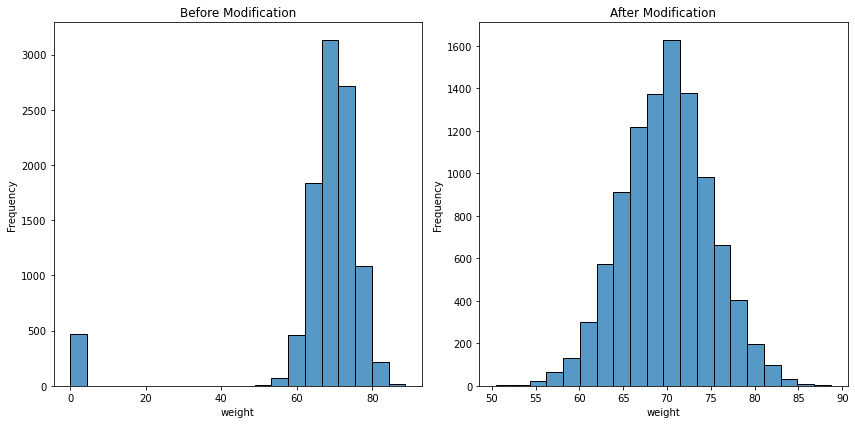

In [463]:
df = distribution_of_outliers(df, 'weight', 40, order='dsc')

In [464]:
df['weight']

0       80.0
1       73.1
2       75.0
3       66.7
4       74.5
        ... 
9995    63.3
9996    69.1
9997    80.9
9998    75.6
9999    70.4
Name: weight, Length: 10000, dtype: float64

#### height ✅  
- Problem: The 'height' column contains excessively high values, such as 401.40395651984.
- Cause: This could be due to data entry errors or anomalies in the dataset.
- Solution: Remove the excessively high values to ensure data consistency and accuracy.

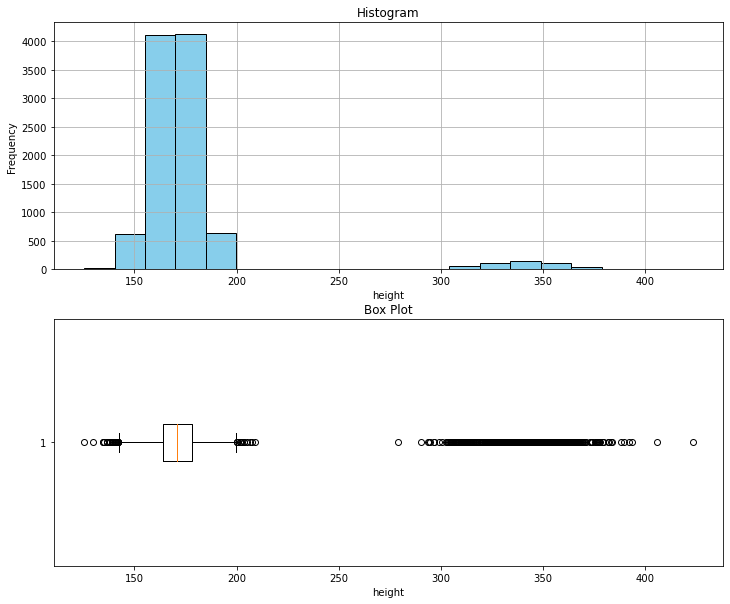

In [465]:
plot_distribution(df,'height')

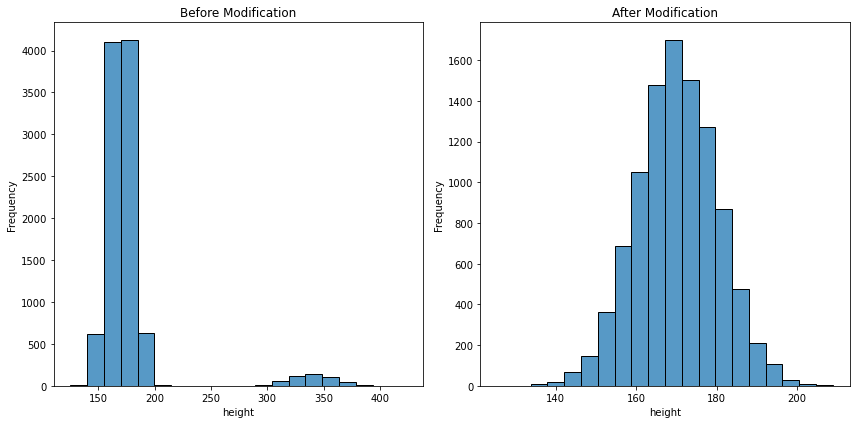

In [466]:
df = distribution_of_outliers(df, 'height', 250, order='asc')

#### bank_balance ✅
- Problem: The 'bank_balance' column might have a consistent shift of +500 in all values, as the data begins at 500.
- Cause: This could be due to a systematic error in recording or processing the data.
- Solution: Subtract 500 from all values in the 'bank_balance' column to correct the systematic shift and ensure consistency in the dataset.

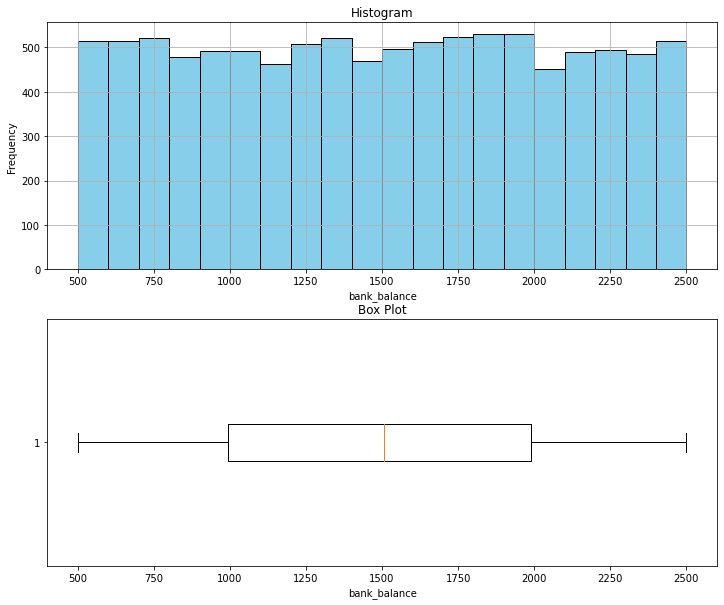

In [467]:
plot_distribution(df,'bank_balance')

In [468]:
df['bank_balance'] = df['bank_balance'] - 500

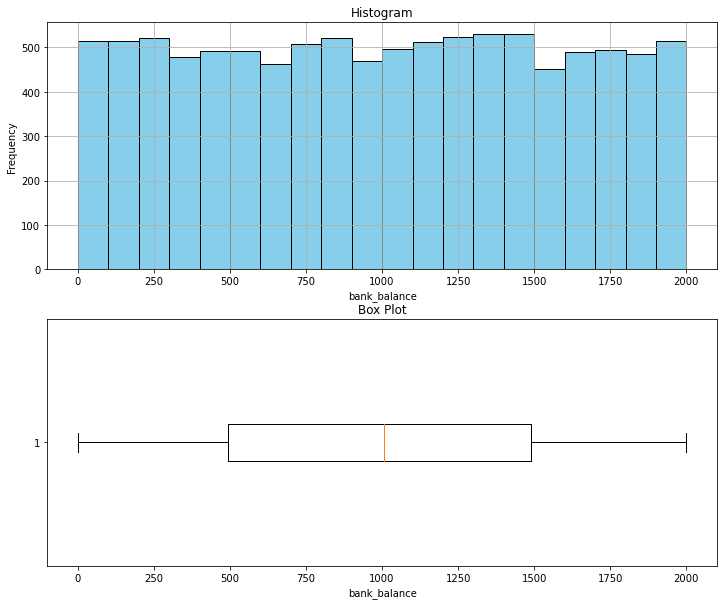

In [469]:
plot_distribution(df,'bank_balance')

#### zip ✅
- Problem: Some values in the 'zip_code' column have fewer than 5 digits, which is invalid for a zip code.
- Cause: This could occur due to data entry errors or incomplete data recording processes.
- Solution: Pad the zip codes with leading zeros until they reach 5 digits to ensure they are valid and consistent in the dataset.

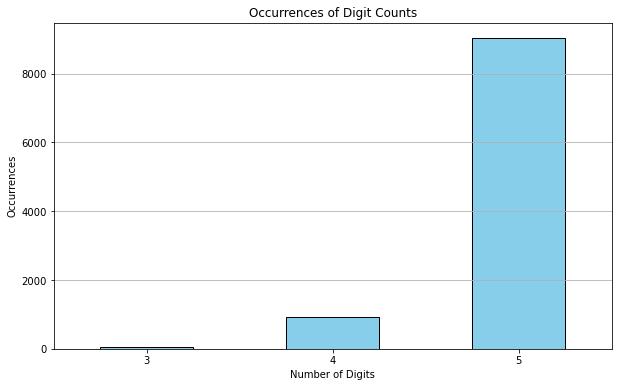

In [470]:
plot_digit_count_distribution(df, 'zip')

In [471]:
df = original_df.copy()

In [472]:
df['zip'] = df['zip'].astype(str).apply(lambda x: x.ljust(5, '0'))


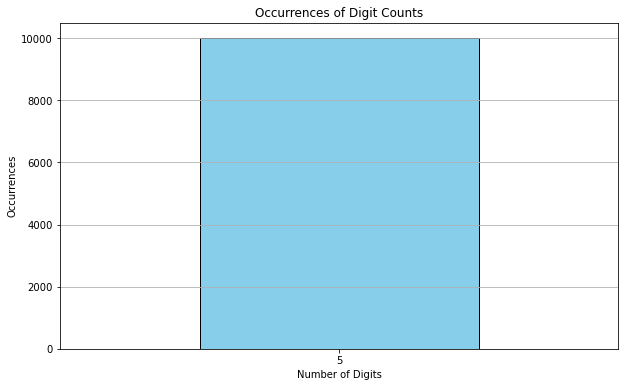

In [473]:
plot_digit_count_distribution(df, 'zip')

### Other ? 0 / 2

#### customer_code ✅ 
- Problem: The 'customer_code' column contains NaN (missing) values.
- Cause: Missing values may occur due to data recording errors or incomplete data.
- Solution: Replace the NaN values with the value 27 to maintain consistency in the dataset, as all other values are 27.

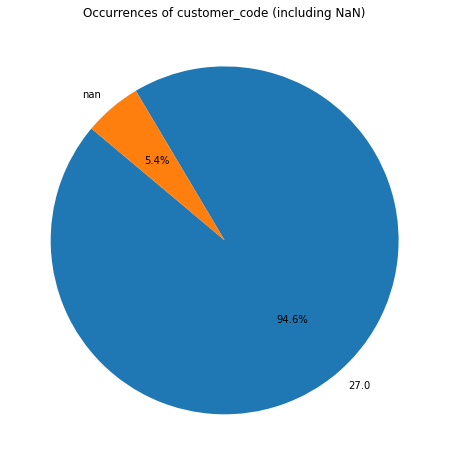

In [474]:
def plot_value_counts_with_nan(df, column_name):
    occurrences = df[column_name].value_counts(dropna=False)

    plt.figure(figsize=(8, 8))
    plt.pie(occurrences, labels=occurrences.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Occurrences of {column_name} (including NaN)')
    plt.show()

plot_value_counts_with_nan(df, 'customer_code')

In [475]:
df['customer_code'] = df['customer_code'].fillna(27)

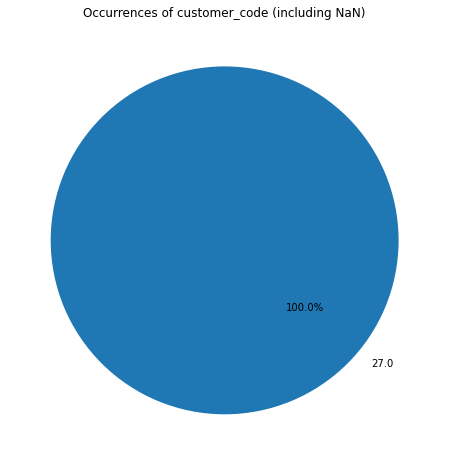

In [476]:
plot_value_counts_with_nan(df, 'customer_code')

#### customer_fico_score ❌  
?
Blank values > maybe use machine learning

# Dirtiness Metrics

In [413]:
df = original_df.copy()

In [347]:
def highlight_diff_row_wise(row):
    return ['color: green' if x != y else '' for x, y in zip(row, original_df.iloc[row.name])]

styled_df = df.head(5).style.apply(highlight_diff_row_wise, axis=1)
styled_df

In [478]:
def calculate_dirtiness(df):
    # Criteria for problematic entries
    # 1. Missing values
    num_missing = df.isna().sum().sum()
    
    # 2. Outliers (example: using a threshold, can be more complex in real scenarios)
    num_outliers = ((df.select_dtypes(include=[np.number]) < 0).sum().sum() + 
                    (df.select_dtypes(include=[np.number]) > 1000000).sum().sum())
    
    # 3. Duplicates
    num_duplicates = df.duplicated().sum()

    # 4. String dirtiness
    num_empty_strings = (df.select_dtypes(include=[object]) == '').sum().sum()
    num_whitespace_strings = (df.select_dtypes(include=[object]).applymap(lambda x: x.isspace() if isinstance(x, str) else False)).sum().sum()
    
    # 5. Invalid emails (only if 'email' column exists)
    if 'email' in df.columns:
        num_invalid_emails = (df['email'].str.contains(r'^[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}$', na=False) == False).sum()
    else:
        num_invalid_emails = 0

    # 6. Date formatting (only if 'date' column exists)
    if 'date' in df.columns:
        num_invalid_dates = 0
        for date_str in df['date']:
            try:
                pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
            except (ValueError, TypeError):
                num_invalid_dates += 1
    else:
        num_invalid_dates = 0

    # 7. Special characters and weird spaces in strings
    acceptable_chars = re.compile(r'^[A-Za-z0-9\s.,@-]*$')
    num_special_chars = (df.select_dtypes(include=[object]).applymap(lambda x: not bool(acceptable_chars.match(x)) if isinstance(x, str) else False)).sum().sum()
    num_weird_spaces = (df.select_dtypes(include=[object]).applymap(lambda x: bool(re.search(r'^\s|\s$|\s{2,}', x)) if isinstance(x, str) else False)).sum().sum()

    # Total problematic entries
    total_problems = (num_missing + num_outliers + num_duplicates + 
                      num_empty_strings + num_whitespace_strings + 
                      num_invalid_emails + num_invalid_dates +
                      num_special_chars + num_weird_spaces)
    
    # Total entries in the DataFrame
    total_entries = df.size
    
    # Calculate dirtiness percentage
    dirtiness_percentage = (total_problems / total_entries) * 100
    
    return dirtiness_percentage

# Calculate and print dirtiness percentage
dirtiness_percentage = calculate_dirtiness(df)
print(f"Dirtiness Percentage: {dirtiness_percentage:.2f}%")

Dirtiness Percentage: 22.18%


In [479]:
dirtiness_percentage = calculate_dirtiness(original_df)
print(f"Dirtiness Percentage: {dirtiness_percentage:.2f}%")

Dirtiness Percentage: 22.30%
